In [3]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import glob
import matplotlib.colors as colors
from matplotlib import cm, animation
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from netCDF4 import Dataset

import scipy.stats as stats
import random

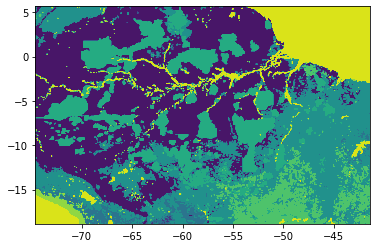

In [4]:
path = '/jet/home/xjliu/Amazon_exp/'
with xr.open_dataset(path+'test801x601_ILdeforested/wrfinput_d01',decode_times=False) as ds:
    lats = ds['XLAT'][0,:,:]
    lons = ds['XLONG'][0,:,:]
    luindex =ds['LU_INDEX']
plt.contourf(lons,lats,luindex[0,:,:])

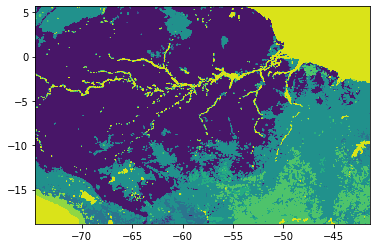

In [5]:
path = '/jet/home/xjliu/Amazon_exp/'
with xr.open_dataset(path+'test801x601/wrfinput_d01',decode_times=False) as ds:
    lats = ds['XLAT'][0,:,:]
    lons = ds['XLONG'][0,:,:]
    luindex =ds['LU_INDEX']
plt.contourf(lons,lats,luindex[0,:,:])

In [3]:
def pdf_Xingu_hourly(landtype):

    year1=np.arange(2001,2010)
    years=np.append(year1,np.arange(2011,2021))
    mean_all = np.empty((19,14))
    right_all = np.empty((19,14))
    left_all = np.empty((19,14))


    for ii, year in enumerate(years):
        file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
        with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
            pass

        if landtype=='clearing':
            data=ds['LH'].where((luindex==12)) # clearing
        elif landtype=='forest':
            data=ds['LH'].where((luindex<=5)) # forest
        elif landtype=='savanna':
            data=ds['LH'].where((luindex>6)&(luindex<11)) # savanna
        else: 
            data=ds['LH']
            print('Data of all the grids are used.')

        for tt,time in enumerate(range(4+3,18+3)): ### 5am to 6pm
            data_sel = data[24+time::24,:,:]  ### drop data of the first day. 
            lh = np.ndarray.flatten(data_sel.values)
            lh = lh[~np.isnan(lh)]

            mean,std=stats.norm.fit(lh) 
            mean_all[ii,tt] = mean

            left,right = stats.norm.interval(0.99,mean,std) 
            left_all[ii,tt] = left
            right_all[ii,tt] = right

    return (mean_all,left_all, right_all)

In [68]:
def bootstrap_ci(data, repetitions = 500, alpha = 0.05, random_state=None): 
    sample_mean = []
    for i in range(repetitions):
            bootstrap_sample = random.choices(data,k=5000)
            #bootstrap_sample = data.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
            avg = np.mean(bootstrap_sample)
            sample_mean = np.hstack((sample_mean,avg))
            
    # confidence interval
    left = np.percentile(sample_mean, alpha/2*100)
    right = np.percentile(sample_mean, 100-alpha/2*100)
    
    return (left,right)

def equation_ci(data):
    ### estimate the dof using Chris' method
    ### DOF = 2*<E>^2/var(E); <E> denotes time average
    ### E = sum(x(t)**2) over N stations
    savanna=ds['LH'][15::24,:,:].where((luindex==12)) # clearing
    tmp = np.reshape(savanna.values,(10,200*160))
    E = np.nansum(tmp*tmp,axis=1)
    dof = 2*E.mean()*E.mean()/E.var()
    
    # CI using the equation
    sample_std_error = stats.sem(lh,ddof=6833-dof)
    left,right = stats.norm.interval(0.95,mean_all[ii,tt], sample_std_error)

def plot_diurnal_withCI(landtype):
    year1=np.arange(2001,2010)
    years=np.append(year1,np.arange(2011,2021))
    mean_all = np.empty((19,14))
    right_all = np.empty((19,14))
    left_all = np.empty((19,14))

    for ii, year in enumerate(years):
        file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
        with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
            pass

        if landtype=='clearing':
            data=ds['LH'].where((luindex==12)) # clearing
        elif landtype=='forest':
            data=ds['LH'].where((luindex<=5)) # forest
        elif landtype=='savanna':
            data=ds['LH'].where((luindex>6)&(luindex<11)) # savanna
        else: 
            data=ds['LH']
            print('Data of all the grids are used.')

        for tt,time in enumerate(range(4+3,18+3)): ### 5am to 6pm
            data_sel = data[time::24,:,:]  ### drop data of the first day. 
            lh = np.ndarray.flatten(data_sel.values)
            lh = lh[~np.isnan(lh)]

            mean_all[ii,tt] = lh.mean()

            # CI using bootstrapping
            #left,right = bootstrap_ci(lh)
            
            # CI using the equation
            #sample_std_error = stats.sem(lh,ddof=6820)
            sample_std_error = lh.std()/np.sqrt(17)
            left,right = stats.norm.interval(0.95,mean_all[ii,tt], sample_std_error)
    
            left_all[ii,tt] = left
            right_all[ii,tt] = right

    return (mean_all,left_all, right_all)

#mean,left,right = plot_diurnal_withCI('clearing')

#### Load data

In [5]:
path = '/ocean/projects/ees210014p/xjliu/Xingu_exp_10day/'
year=2001
file = path+'post_processing/dif.energy.'+str(year)+'.mediumclearing.ndays.nc'
print(file)
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
    lats=ds['XLAT'][0,:,0]
    lons=ds['XLONG'][0,0,:]

### LU_INDEX
file = path+'Xingu_2005_bigclearing/3Dfields_d01_2005-11-10_00:00:00'
print(file)
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    luindex=ds1['LU_INDEX'][0,:,:]

/ocean/projects/ees210014p/xjliu/Xingu_exp_10day/post_processing/dif.energy.2001.mediumclearing.ndays.nc
/ocean/projects/ees210014p/xjliu/Xingu_exp_10day/Xingu_2005_bigclearing/3Dfields_d01_2005-11-10_00:00:00


## Use the standard method to calculate the Confidence interval

In [17]:
# Show the clearing region (luindex=12), forests region (luindex<=5) and savanna region (Luindex=8[woody savanna],9,10[grassland])
year1=np.arange(2001,2010)
years=np.append(year1,np.arange(2011,2021))
mean_all = np.empty((19))

for ii, year in enumerate(years):
    file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
    with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
        pass
    ### Mask using LUindex, forests
    #savanna=ds['LH'][39::24,10:-10,10:-10].where((luindex[10:-10,10:-10]>6)&(luindex[10:-10,10:-10]<11)) # Savanna
    #savanna=ds['LH'][39::24,20:-20,20:-20].where((luindex[20:-20,20:-20]<=5)) # Forests
    savanna=ds['LH'][9*24+15,:,:].where((luindex==12)) # clearing

    lh = np.ndarray.flatten(savanna.values)
    lh = lh[~np.isnan(lh)]

    mean_all[ii],std=stats.norm.fit(lh) 
    
    
    repetitions=1000
    bootstrap_sample_size = len(lh) 
    sample_mean = []
    alpha=0.05
    for i in range(repetitions):
            bootstrap_sample = random.choices(lh,k=1000)
            #bootstrap_sample = data.sample(n = bootstrap_sample_size, replace = True, random_state = random_state)
            avg = np.mean(bootstrap_sample)
            sample_mean = np.hstack((sample_mean,avg))
            
    # confidence interval
    left = np.percentile(sample_mean, alpha/2*100)
    right = np.percentile(sample_mean, 100-alpha/2*100)
    

    #print(mean_all[ii],left,right)
#print(mean_all)

## Use bootstrapping method for Confidence interval calculation

## To-do
### 1. All 10 days hourly data
### 2. All 10 days day-time data
### 3. All 10 days morning/noon/afternnon (based on diurnal cycle) data
### 4. All 10 days morning/noon/afternoon data of the area-average.

### 1. Diurnal cycle with CI, using all 10 days' hourly data

Text(0.5, 0.92, 'Diurnal cycle of mean LH change over Clearing')

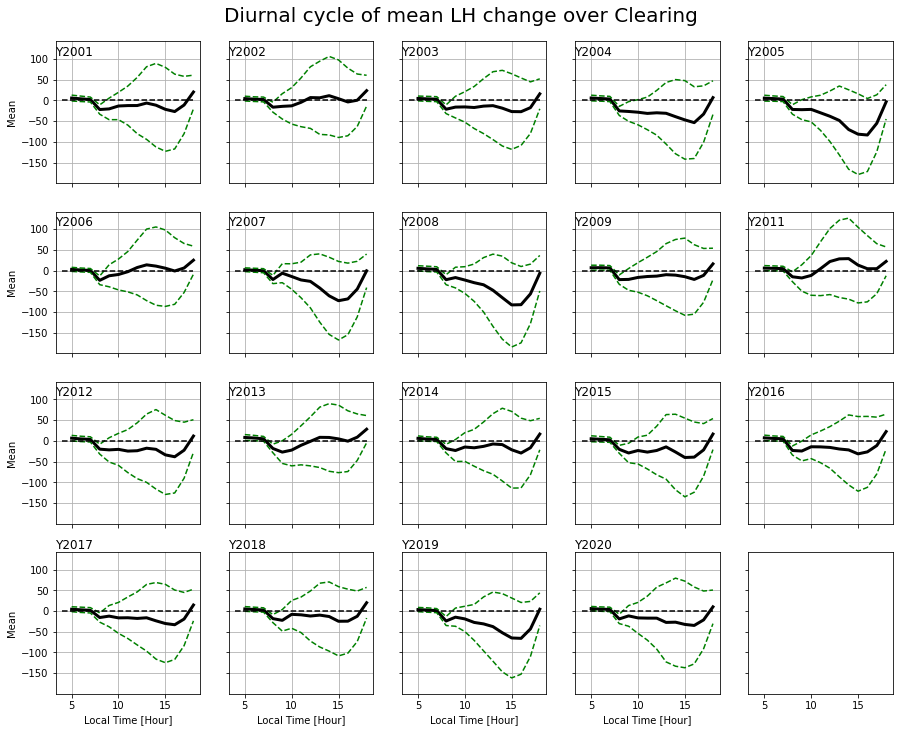

In [69]:
year1=np.arange(2001,2010)
years=np.append(year1,np.arange(2011,2021))

mean,left,right = plot_diurnal_withCI('clearing')
#sample_std_error = stats.sem(lh,ddof=6833-dof)
#left,right = stats.norm.interval(0.95,mean_all[ii,tt], sample_std_error)
fig,axes = plt.subplots(4,5,figsize=(15,12),sharex=True,sharey=True)
axes = axes.ravel()  
axes2 = axes

for ii in range(19):
    color1 = 'tab:blue'
    axes[ii].plot(np.arange(5,19),mean[ii,:],color='k',linewidth=3)
    axes[ii].plot(np.arange(5,19),left[ii,:],'--g')
    axes[ii].plot(np.arange(5,19),right[ii,:],'--g')
    axes[ii].plot([4,18],[0,0],'--k')
    axes[ii].grid()
    axes[ii].set_title('Y'+str(years[ii]),loc='left',pad=-14)
    #axes[ii].tick_params(axis='y', labelcolor='tab:blue')
    
    if ii%5==0:
        axes[ii].set_ylabel('Mean') ## This will be set to the right y-axis if set after twinx.
    
            
for vv in range(15,19):
    axes[vv].set_xlabel('Local Time [Hour]') ## Not sure why this is not shown


fig.suptitle('Diurnal cycle of mean LH change over Clearing',fontsize=20,y=0.92)

#fig.tight_layout()

### 2. Difference with CI using 10 days' day-time data

Text(0.5, 1.0, '10am to 5pm')

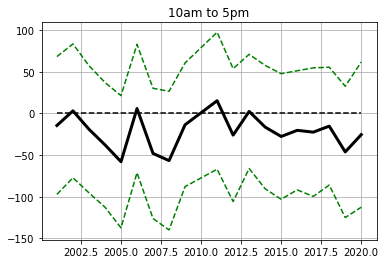

In [65]:
### 
mean_all = np.empty((19))
LCI_all = np.empty((19))
RCI_all = np.empty((19))

time_sel = []
for ii in range(10+3,17+3): #10am to 5pm
    for iday in range(10):
        time_sel.append(ii+24*iday)

### get the pdf of the data
for ii, year in enumerate(years):
    file = path+'post_processing/dif.energy.'+str(year)+'.bigclearing.ndays.nc'
    with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds:
        pass
    ### Mask using LUindex
    savanna=ds['LH'][time_sel,:,:].where((luindex==12)) # clearing

    lh = np.ndarray.flatten(savanna.values)
    lh = lh[~np.isnan(lh)]

    mean_all[ii],std=stats.norm.fit(lh) 
   
    ### Get the confidence interval
    #LCI_all[ii],RCI_all[ii] = bootstrap_ci(lh)
    sample_std_error = lh.std()/np.sqrt(17)
    #print(sample_std_error)
    LCI_all[ii],RCI_all[ii] = stats.norm.interval(0.95,mean_all[ii], sample_std_error)

plt.plot(years,mean_all,'-k',linewidth=3)
plt.plot([2001,2020],[0,0],'--k')
plt.plot(years,LCI_all,'--g')
plt.plot(years,RCI_all,'--g')
plt.grid()
plt.title('10am to 5pm')

In [53]:
LCI_all

array([        nan, 37.91534342,         nan,         nan,         nan,
       36.89086189,         nan,         nan,         nan, 39.85024658,
               nan, 31.38239556,         nan,         nan,         nan,
               nan,         nan,         nan,         nan])